In [10]:
#importing to download youtube videos
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import time

# Importing Pandas to create DataFrame
import pandas as pd
# Importing numpy
import numpy as np

#importing for plot data visualization
import seaborn as sns
import matplotlib.pyplot as plt



In [11]:
def ScrapComment(url):
    option = webdriver.ChromeOptions()
    option.add_argument("--headless")
    driver = webdriver.Chrome(executable_path=ChromeDriverManager().install(), options=option)
    driver.get(url)
    time.sleep(10)
    prev_h = 0
    while True:
        height = driver.execute_script("""
                function getActualHeight() {
                    return Math.max(
                        Math.max(document.body.scrollHeight, document.documentElement.scrollHeight),
                        Math.max(document.body.offsetHeight, document.documentElement.offsetHeight),
                        Math.max(document.body.clientHeight, document.documentElement.clientHeight)
                    );
                }
                return getActualHeight();
            """)
        driver.execute_script(f"window.scrollTo({prev_h},{prev_h + 200})")
        # fix the time sleep value according to your network connection
        time.sleep(1)
        prev_h +=300  
        if prev_h >= height:
            break
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    driver.quit()
    title_text_div = soup.select_one('#container h1')
    title = title_text_div and title_text_div.text
    comment_div = soup.select("#content #content-text")
    comment_list = [x.text for x in comment_div]
    print(title, comment_list)
    df =pd.DataFrame(comment_list,columns=['comments'])
    df["sentiments"] = ""

    return df


In [12]:
if __name__ == "__main__":

    url = input("Enter your url:")
    
    df = ScrapComment(url)

C:\Users\11ani\AppData\Local\Temp\ipykernel_26320\221152334.py:4: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(executable_path=ChromeDriverManager().install(), options=option)


मिनीरल वाटर मत खान्न क्वाटर bhajani mahotsav | eleena chauhan new nepali song 2079/2023 ['lo poco que he podido entender de esta cancion es el mensaje de amor propio a las mujeres , a las adolencestes les dice no hay afan de nada  , me encanta la cancion y el mensaje', 'Esta canción se ve que es más fuerte que la ayahuasca.....veo que todas las niñas entran en trance jaja', 'El final más brutal que concierto de metal !!!', 'Vi que significa esa canción y tiene una letra muy hermosa, la voz de la que canta es muy bonita.', "I'm Punjabi don't understand what is she saying but still enjoying.. love from Pakistan", 'Pues Tiene buen ritmo la música', 'เพลงเพราะมากๆครับ/ผมฟังทุกคืน/หัดร้องแต่ลิ้นร้องไม่ทัน', 'Solo vine por la niña de chaqueta rosa ', 'ม่วน', 'Eleena Chauhan  Nepal 🇳🇵 ', 'El final epico con los polis', 'Yo buscando a la niña de rosa por aquí también ', 'Alguem me fala onde encontro a tradução dessa musica ? Kkkk vi pela a menjna de rosa', 'Love miniral watara from Indonesia',

In [13]:
#importing string,nltk and re for text preprocessing
import string

from nltk.corpus import stopwords

from nltk import pos_tag

from nltk.corpus import wordnet

from nltk.stem import WordNetLemmatizer

import re


In [14]:
#function that processes the comments and returns clean_comments

def text_preprocessing(data):

    

    #convert to lowercase
    data['clean_comments'] = data['comments'].str.lower()

    #removing empty columns
    data['clean_comments'].replace('', np.nan, inplace=True)
    data.dropna(subset=['clean_comments'], inplace=True)

    #removing urls and html tags
    data['clean_comments'] = data['clean_comments'].apply(lambda x: re.sub(r'https?://\S+www\.\S+', ' ', x))
    data['clean_comments'] = data['clean_comments'].apply(lambda x: re.sub(r'<.*?>', ' ', x))

    #removing punctuations
    punctuation = string.punctuation
    data['clean_comments'] = data['clean_comments'].astype(str)
    data['clean_comments'] = data['clean_comments'].apply(lambda x: x.translate(str.maketrans('','',punctuation)))

    #removing stopwords
    STOPWORDS = set(stopwords.words('english'))
    data['clean_comments'] = data['clean_comments'].apply(lambda x: " ".join([w for w in x.split() if w not in STOPWORDS]))

    #remove non english words
    #WORDS = set(words.words())
    #data['clean_comments'] = data['clean_comments'].apply(lambda x: " ".join(w for w in x.split() if w in WORDS))

    #removing special characters
    data['clean_comments'] = data['clean_comments'].apply(lambda x: re.sub('[^a-zA-Z0-9]', ' ', x))
    data['clean_comments'] = data['clean_comments'].apply(lambda x: re.sub('\s+', ' ', x))

    #stemization
    #ps = PorterStemmer()
    #data['clean_comments'] = data['clean_comments'].apply(lambda x: " ".join([ps.stem(w) for w in x.split()]))

    #lemmatization and pos tagging
    lemmatizer = WordNetLemmatizer()
    wordnet_map = {"N":wordnet.NOUN,"V":wordnet.VERB,"J":wordnet.ADJ,"R":wordnet.ADV}
    data['clean_comments'] = data['clean_comments'].apply(lambda x: " ".join([lemmatizer.lemmatize(w,wordnet_map.get(pos[0],wordnet.NOUN)) for w, pos in pos_tag(x.split())]))
    
    #removing empty columns
    data['clean_comments'].replace('', np.nan, inplace=True)
    data.dropna(subset=['clean_comments'], inplace=True)

    #removing null value
    #data['clean_comments'].dropna(how = any, axis = 0)

    #word tokanize
    #data['clean_comments'] = data['clean_comments'].apply(lambda x: word_tokenize(x))
    #data
    
    return data



In [15]:
#process the text
df = text_preprocessing(df)
df

,comments,sentiments,clean_comments
0,lo poco que he podido entender de esta cancion...,,lo poco que podido entender de esta cancion e ...
1,Esta canción se ve que es más fuerte que la ay...,,esta canci n se que es m s fuerte que la ayahu...
2,El final más brutal que concierto de metal !!!,,el final m s brutal que concierto de metal
3,Vi que significa esa canción y tiene una letra...,,vi que significa esa canci n tiene una letra m...
4,I'm Punjabi don't understand what is she sayin...,,im punjabi dont understand say still enjoy lov...
5,Pues Tiene buen ritmo la música,,pues tiene buen ritmo la m sica
7,Solo vine por la niña de chaqueta rosa,,solo vine por la ni a de chaqueta rosa
9,Eleena Chauhan Nepal 🇳🇵,,eleena chauhan nepal
10,El final epico con los polis,,el final epico con los polis
11,Yo buscando a la niña de rosa por aquí también,,yo buscando la ni a de rosa por aqu tambi n


In [16]:
def sentence_to_words(sentence):

    l = sentence.split()  # split sentence into individual word(tokanize)
    p = ''
    word_list = []

    for word in l:

        p = ''

        for letter in word:

            if ord(letter) >= 67 and ord(letter) <= 122:
                p = p + letter
        word_list.append(p)

    return word_list  # return the word list of the input comments

def naive_bayes_predict(X, bag, prior_pos, prior_neg):
    Y = []

    for i in range(len(X)):
        k_pos = 1
        k_neg = 1
        p = sentence_to_words(X[i])

        for k in range(len(bag)):

            for word in p:

                if word == bag['index'][k]:
                    k_pos = k_pos * bag['sent=positive'][k] #product of likelihood prob given the word is present in vocabulary 
                    k_neg = k_neg * bag['sent=negative'][k]

        nb = [prior_neg * k_neg, prior_pos * k_pos] # multiply each likelihood prob with the prior prob
        Y.append(np.argmax(nb))

    return Y

In [20]:
df.loc[82] = ["I like your videos",'',"like video"]
df.loc[83] = ["I hate your videos",'', "hate video"]

Z = df['clean_comments']
Z = Z.reset_index(drop=True)

#opening bag of words we have created and finding P(c) as prior_pos and P(n) as prior_neg
bag = pd.read_csv("bag.csv", index_col=[0])
prior = pd.read_csv("prior.csv", index_col=[0])

prior_pos = prior.iloc[0]['prior']  # prior probability for  class
prior_neg = prior.iloc[1]['prior']  #prior probability for class 

#print(prior_pos,prior_neg)

z_predicted = naive_bayes_predict(Z, bag, prior_pos, prior_neg)
#z_predicted

#saving predicted sentiments into dataframe and to csv
df['sentiments'] = z_predicted
df.to_csv("C:\\Users\\11ani\\OneDrive\Desktop\\project 7th sem code\\predected_comments\\"+"temp.csv")
print(df)

                                             comments  sentiments  \
0   lo poco que he podido entender de esta cancion...           0   
1   Esta canción se ve que es más fuerte que la ay...           0   
2      El final más brutal que concierto de metal !!!           0   
3   Vi que significa esa canción y tiene una letra...           0   
4   I'm Punjabi don't understand what is she sayin...           1   
..                                                ...         ...   
78                                               Nice           1   
79                                               Nice           1   
80                                              Super           1   
81                                              Super           1   
82                                 I like your videos           1   

                                       clean_comments  
0   lo poco que podido entender de esta cancion e ...  
1   esta canci n se que es m s fuerte que la ayahu...  
2  

length= 60 
pos_count 42 
neg_count 18
                                             comments  sentiments  \
0   lo poco que he podido entender de esta cancion...           0   
1   Esta canción se ve que es más fuerte que la ay...           0   
2      El final más brutal que concierto de metal !!!           0   
3   Vi que significa esa canción y tiene una letra...           0   
4   I'm Punjabi don't understand what is she sayin...           1   
5                     Pues Tiene buen ritmo la música           1   
7             Solo vine por la niña de chaqueta rosa            1   
9                           Eleena Chauhan  Nepal 🇳🇵            1   
10                       El final epico con los polis           1   
11    Yo buscando a la niña de rosa por aquí también            0   
12  Alguem me fala onde encontro a tradução dessa ...           0   
13                 Love miniral watara from Indonesia           0   
14  Para toda Latinoamérica: "El pantalón"  Mira e...           

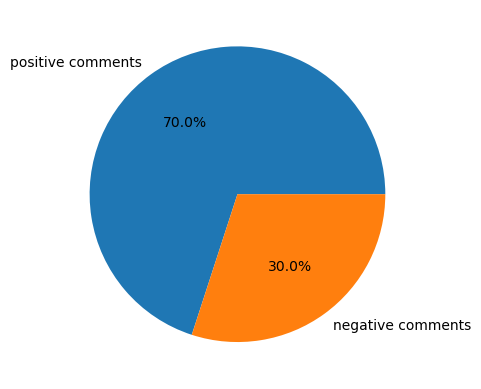

In [18]:
#analysis of comments
length = len(df)  # finding out length of the datframe
pos_count = len(df[df['sentiments'] == 1])  # counting positive_sentiments
neg_count = len(df[df['sentiments'] == 0])  # counting negative_sentiments
print ('length=',length,'\npos_count',pos_count,'\nneg_count',neg_count,)

y = np.array([pos_count,neg_count])
mylabels = ["positive comments", "negative comments"]
print(df)
plt.pie(y, labels= mylabels,  autopct='%1.1f%%')
plt.show() 